In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
data = sns.load_dataset('flights')
data

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [4]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
year,144.0,NaN,NaN,NaN,1954.5,3.464102,1949.0,1951.75,1954.5,1957.25,1960.0
month,144,12,Jan,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passengers,144.0,NaN,NaN,NaN,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [6]:
data['month'] = data['month'].map({'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'})

In [7]:
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str)

In [8]:
data['date'] = pd.to_datetime(data['date'])

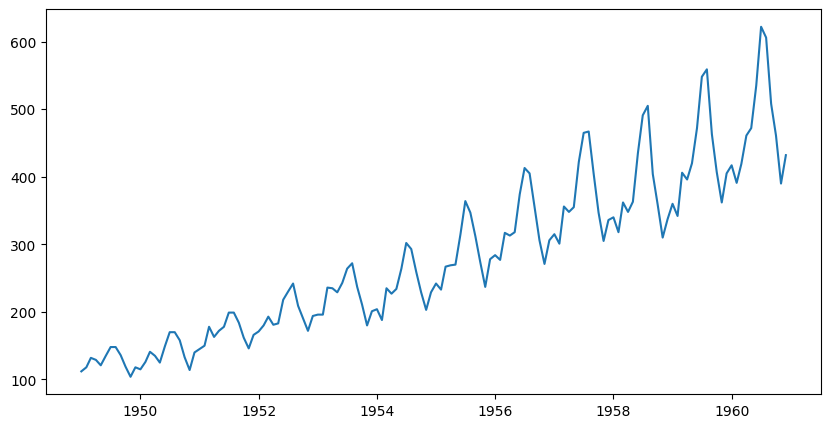

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['passengers'])
plt.show()

<Axes: xlabel='year'>

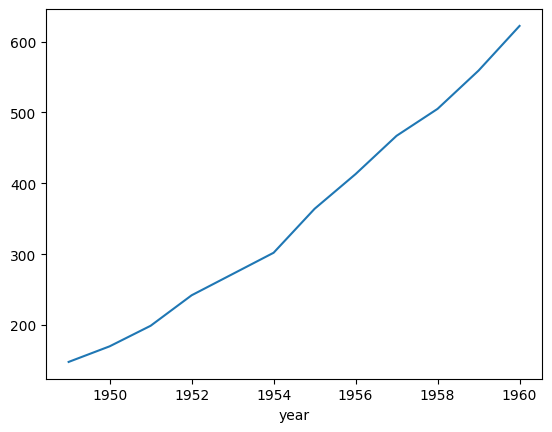

In [10]:
data.groupby('year')['passengers'].max().plot()

In [11]:
data = pd.DataFrame(data)
data = data.set_index('date')
data = data['passengers']

In [12]:
# checking for stationarity
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    if dftest[1] <= 0.05:
        print("strong evidence against null hypothesis, reject null hypothesis")
        print("data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adf_test(data)

1. ADF :  0.8153688792060482
2. P-Value :  0.991880243437641
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression: 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


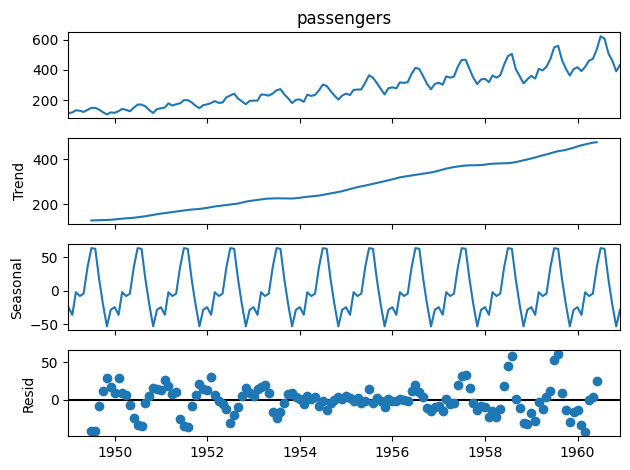

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

decompose = seasonal_decompose(data,model='additive', period=12)
decompose.plot()
plt.show()

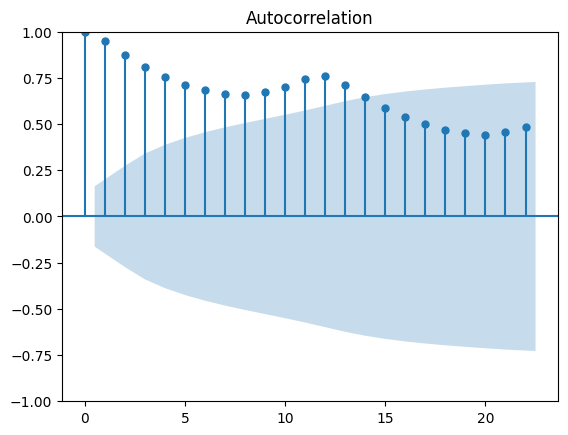

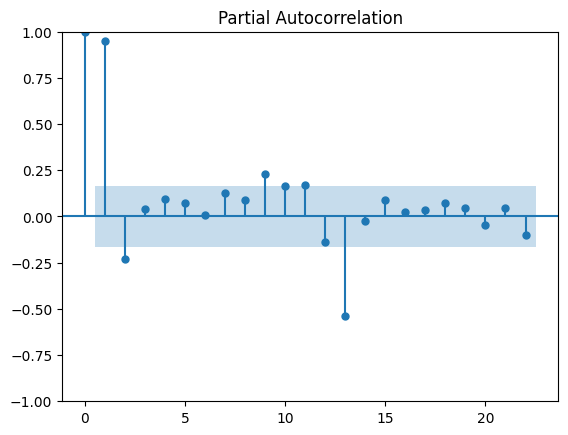

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(data)
pacf_original = plot_pacf(data)

In [15]:
# differencing
data_diff = data - data.shift(2)
data_diff = data_diff.dropna()
adf_test(data_diff)

1. ADF :  -2.9616951355554244
2. P-Value :  0.03862975767698839
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598
strong evidence against null hypothesis, reject null hypothesis
data has no unit root and is stationary


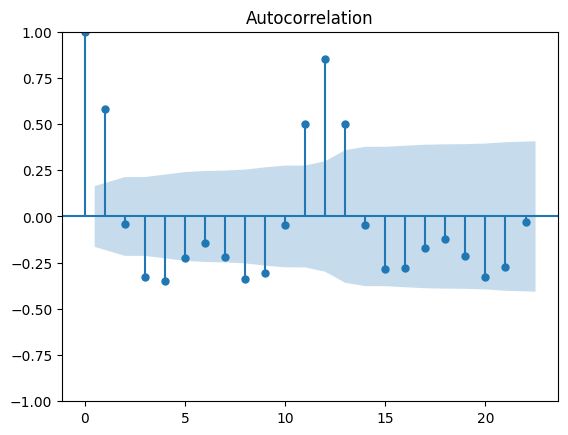

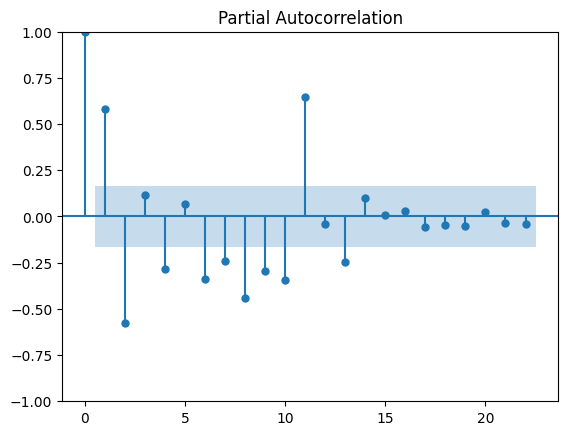

In [16]:
acf_diff = plot_acf(data_diff)
pacf_diff = plot_pacf(data_diff)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

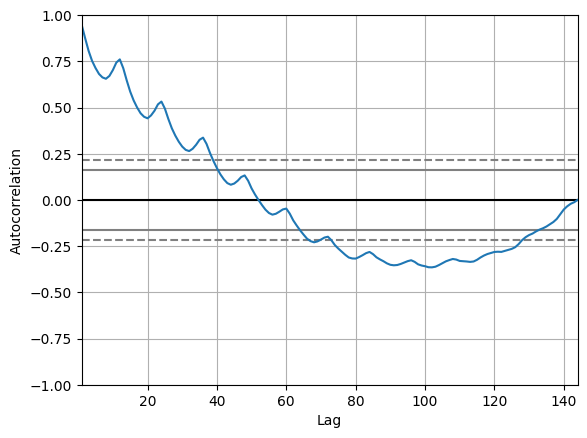

In [17]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data)

In [18]:
data.shape[0]*0.2

28.8

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import itertools
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


p = range(0, 8)
d = range(0, 8)
q = range(0, 8)

pdq = list(itertools.product(p, d, q))
results = []

train = data[:-29]
test = data[-29:]  

for param in pdq:
    try:
        model = SARIMAX(train, order=param, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        results.append([param, model_fit.aic])
    except:
        continue

results = pd.DataFrame(results)
results.columns = ['pdq', 'aic']
results.sort_values('aic').head(5)

,pdq,aic
461,"(7, 1, 5)",931.308443
462,"(7, 1, 6)",931.763067
460,"(7, 1, 4)",935.296734
463,"(7, 1, 7)",939.071420
271,"(4, 1, 7)",943.358349


In [20]:
# Fitting the model
model = SARIMAX(data, order=(7, 1, 5), seasonal_order=(7, 1, 5, 12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  144
Model:             SARIMAX(7, 1, 5)x(7, 1, 5, 12)   Log Likelihood                -491.263
Date:                            Mon, 18 Dec 2023   AIC                           1032.527
Time:                                    18:33:50   BIC                           1104.407
Sample:                                01-01-1949   HQIC                          1061.735
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4480      2.380     -0.188      0.851      -5.113       4.217
ar.L2         -0.0512      0.442     -0.116      0.908      -0.917       0.814
ar.L3         -0.3583      0.179     -2.006      0.045      -0.708      -0.008
ar.L4          0.4870      0.859      0.567      0.571      -1.196       2.171
ar.L5          0.5485      1.465      0.374      0.708      -2.322       3.419
ar.L6          0.1128      0.865      0.130      0.896      -1.582       1.808
ar.L7         -0.0586      0.167     -0.351      0.725      -0.386       0.269
ma.L1          0.0285      6.841      0.004      0.997     -13.380      13.437
ma.L2         -0.0786      7.396     -0.011      0.992     -14.575      14.418
ma.L3          0.3085      5.837      0.053      0.958     -11.132      11.749
ma.L4         -0.8906      5.742     -0.155      0.877     -12.145      10.363
ma.L5         -0.3064      3.663     -0.084      0.933      -7.485       6.873
ar.S.L12      -0.3144      9.770     -0.032      0.974     -19.464      18.835
ar.S.L24       0.5368      8.491      0.063      0.950     -16.105      17.178
ar.S.L36       0.5837      2.945      0.198      0.843      -5.188       6.355
ar.S.L48       0.1486      6.452      0.023      0.982     -12.496      12.793
ar.S.L60      -0.1271      4.343     -0.029      0.977      -8.640       8.386
ar.S.L72       0.0414      3.952      0.010      0.992      -7.704       7.787
ar.S.L84      -0.1241      3.194     -0.039      0.969      -6.385       6.136
ma.S.L12       0.0998     10.552      0.009      0.992     -20.582      20.781
ma.S.L24      -0.5035      7.264     -0.069      0.945     -14.741      13.734
ma.S.L36      -0.4848      3.710     -0.131      0.896      -7.756       6.786
ma.S.L48       0.1288      7.129      0.018      0.986     -13.845      14.102
ma.S.L60       0.4439      4.178      0.106      0.915      -7.744       8.632
sigma2        88.6620    712.536      0.124      0.901   -1307.883    1485.207
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.44
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

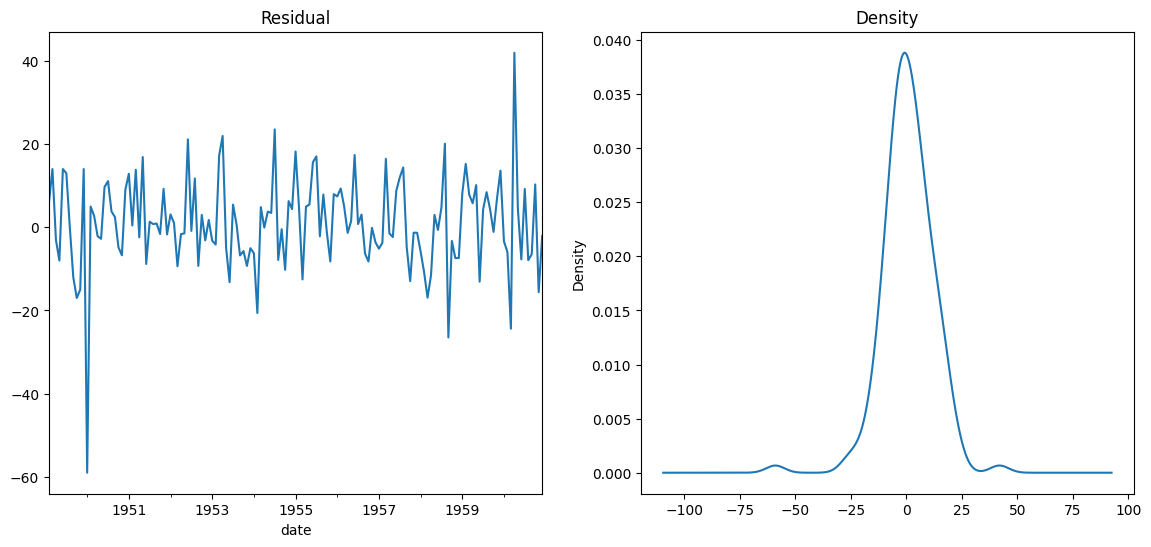

In [21]:
residual = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize = (14,6))
residual.plot(title = 'Residual', ax = ax[0])
residual.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

In [22]:
data.tail()

date
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, dtype: int64

<Axes: xlabel='date'>

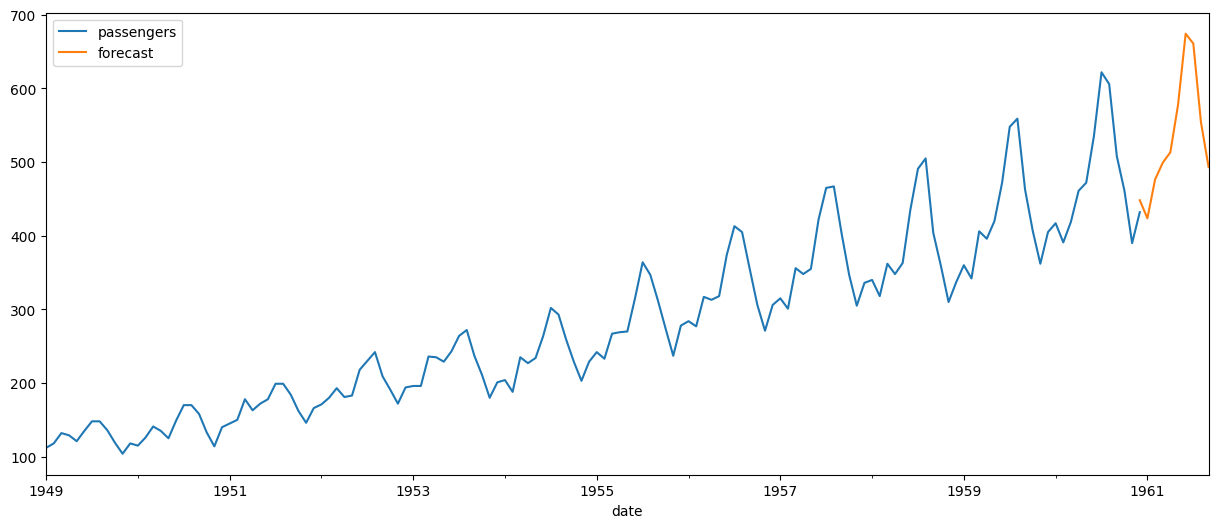

In [28]:
# Forecast
data = pd.DataFrame(data)
data.columns = ['passengers']

forecast_10 = pd.date_range(start='1960-12-01', periods=10, freq='MS')
forecast_test = model_fit.forecast(len(forecast_10))  

# Create a separate DataFrame for the forecast
forecast_data = pd.DataFrame({'forecast': list(forecast_test)}, index=forecast_10)

# Plot both 'order' and 'forecast'
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(ax=ax)
forecast_data.plot(ax=ax)


In [24]:
import pmdarima as pm
auto_arima = pm.auto_arima(data
                           , start_p=0
                           , start_q=0
                           , max_p=6
                           , max_q=6
                           , m=12
                           , seasonal=True
                           , d=1
                           , D=1
                           , trace=True
                           , error_action='ignore'
                           , suppress_warnings=True
                           , stepwise=True
                           , scoring='mse'
                           , information_criterion='aic'
                           , out_of_sample_size=20
                           , scoring_args={}
                           , with_intercept=False
                           )
auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.163, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1021.626, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1022.553, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1021.771, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1021.053, Time=0.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.126, Time=0.46 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1022.425, Time=0.70 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1022.471, Time=0.65 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1020.803, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1021.352, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(0,1,1)(1,1,1)[12]          

ARIMA(order=(0, 1, 1), out_of_sample_size=20, scoring_args={},
      seasonal_order=(2, 1, 0, 12), suppress_warnings=True,
      with_intercept=False)

In [25]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -506.401
Date:                             Mon, 18 Dec 2023   AIC                           1020.803
Time:                                     18:34:05   BIC                           1032.303
Sample:                                          0   HQIC                          1025.476
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3673      0.066     -5.598      0.000      -0.496      -0.239
ar.S.L12      -0.1197      0.080     -1.503      0.133      -0.276       0.036
ar.S.L24       0.2604      0.093      2.809      0.005       0.079       0.442
sigma2       114.3383     11.891      9.615      0.000      91.032     137.645
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.93
Prob(Q):                              0.77   Prob(JB):                         0.08
Heteroskedasticity (H):               2.73   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

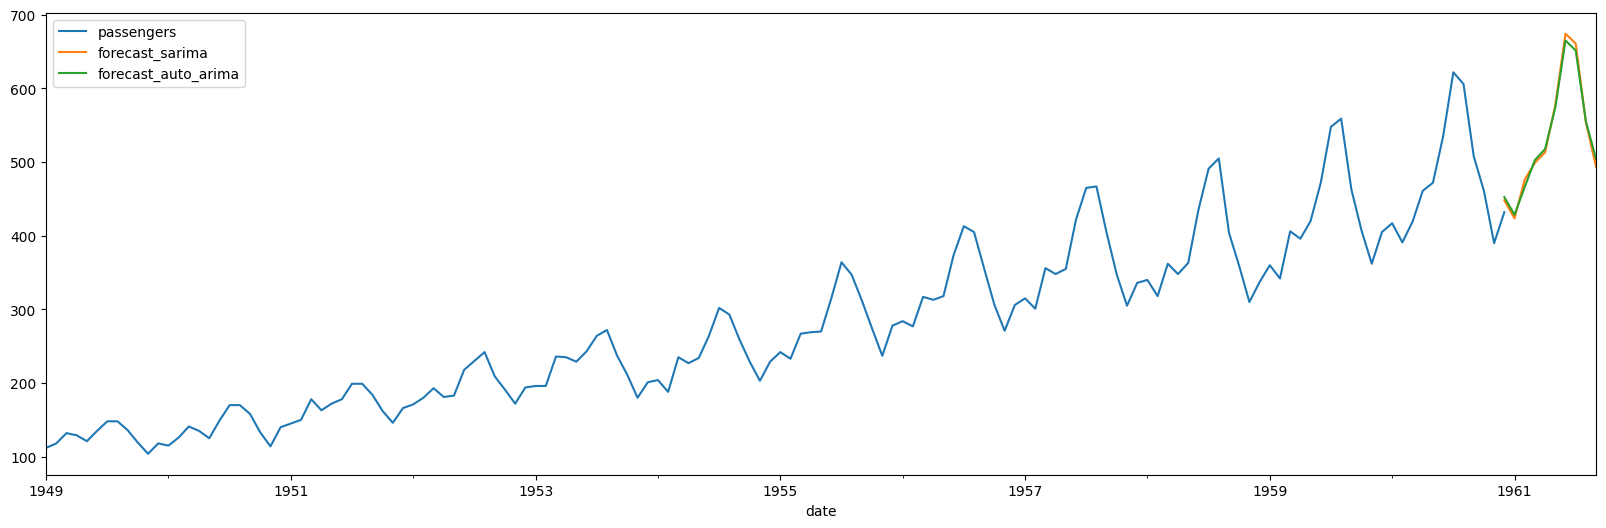

In [32]:

forcast_auto_arima = auto_arima.predict(len(forecast_10))
# Create a separate DataFrame for the forecast
forecast_data = pd.DataFrame({'forecast_sarima': list(forecast_test)}, index=forecast_10)
forcast_auto_arima = pd.DataFrame({'forecast_auto_arima': list(forcast_auto_arima)}, index=forecast_10)
# Plot both 'order' and 'forecast'
ax = data.plot(legend=True)
forecast_data.plot(ax=ax, legend=True, figsize=(20, 6))
forcast_auto_arima.plot(ax=ax, legend=True)
